In [39]:
import sys
import re
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from requests import get
from tqdm import tqdm
from bs4 import BeautifulSoup as soup
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

from pydotmap import DotMap
%matplotlib inline

class PinterestImageScraper:

    def __init__(self):
        self.json_data_list = []
        self.unique_img = []

    @staticmethod
    def clear():
        if os.name == 'nt':
            _ = os.system('cls')
        else:
            _ = os.system('clear')

    # ---------------------------------------- GET GOOGLE RESULTS ---------------------------------
    @staticmethod
    def get_pinterest_links(body):
        searched_urls = []
        html = soup(body, 'html.parser')
        links = html.select('#main > div > div > div > a')
        #print('[+] saving results ...')
        for link in links:
            link = link.get('href')
            link = re.sub(r'/url\?q=', '', link)
            if link[0] != "/" and "pinterest" in link:
                searched_urls.append(link)

        return searched_urls


    # -------------------------- save json data from source code of given pinterest url -------------
    def get_source(self, url):
        try:
            res = get(url)
        except Exception as e:
            return
        html = soup(res.text, 'html.parser')
        # get json data from script tag having id initial-state
        json_data = html.find_all("script", attrs={"id": "__PWS_DATA__"})
        for a in json_data:
            self.json_data_list.append(a.string)

    # --------------------------- READ JSON OF PINTEREST WEBSITE ----------------------
    def save_image_url(self):
        #print('[+] saving image urls ...')
        url_list = [i for i in self.json_data_list if i.strip()]
        if not len(url_list):
            return url_list
        url_list = []
        for js in self.json_data_list:
            try:
                data = DotMap(json.loads(js))
                urls = []
                for pin in data.props.initialReduxState.pins:
                    if isinstance(data.props.initialReduxState.pins[pin].images.get("orig"), list):
                        for i in data.props.initialReduxState.pins[pin].images.get("orig"):
                            urls.append(i.get("url"))
                    else:
                        urls.append(data.props.initialReduxState.pins[pin].images.get("orig").get("url"))

                for url in urls:
                    url_list.append(url)
            except Exception as e:
                continue
        
        url_list1 = url_list[0:10]
        return list(set(url_list1))
    
        

    # ------------------------------ image hash calculation -------------------------
    def dhash(self, image, hashSize=8):
        resized = cv2.resize(image, (hashSize + 1, hashSize))
        diff = resized[:, 1:] > resized[:, :-1]
        return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

    # ------------------------------  save images  ---------------------------
    def saving_op(self, var):
        
        url_list1, folder_name = var
        if not os.path.exists(os.path.join(os.getcwd(), folder_name)):
                os.mkdir(os.path.join(os.getcwd(), folder_name))
        for img in tqdm(url_list1):
            result = get(img, stream=True).content
            file_name = img.split("/")[-1]
            file_path = os.path.join(os.getcwd(), folder_name, file_name)
            img_arr = np.asarray(bytearray(result), dtype="uint8")
            image = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
            if not self.dhash(image) in self.unique_img:
                cv2.imwrite(file_path, image)
            self.unique_img.append(self.dhash(image))
            print("", end="\r")
        

    # ------------------------------  show images from image url list ----------------------------
    def download(self, url_list1,keyword):
       
        folder_name = keyword
        num_of_workers = 10
        idx = len(url_list1) // num_of_workers if len(url_list1) > 9 else len(url_list1)
        param = []
        for i in range(num_of_workers):
            param.append((url_list1[((i*idx)):(idx*(i+1))], folder_name))
        with ThreadPoolExecutor(max_workers=num_of_workers) as executor:
            executor.map(self.saving_op, param)

        z=0
        while z<10:
            print(url_list1[z])
            z=z+1
          
        
        #PinterestImageScraper.clear()
        
        

    # -------------------------- get user keyword and pinterest search for that keywords ---------------------
    @staticmethod
    def start_scraping(key=None):
        try:
            key = input("Enter keyword: ") if key == None else key
            keyword = key + " pinterest"
            keyword = keyword.replace("+", "%20")
            url = f'http://www.google.co.in/search?hl=en&q={keyword}'
            print('[+] starting search ...')
            res = get(url)
            searched_urls = PinterestImageScraper.get_pinterest_links(res.content)
        except Exception as e:
            return []

        return searched_urls, key.replace(" ", "_")


    def make_ready(self, key=None):
        extracted_urls, keyword = PinterestImageScraper.start_scraping(key)

        for i in extracted_urls:
            self.get_source(i)

        # get all urls of images and save in a list
        url_list1 = self.save_image_url()
        return_data = {
            "isDownloaded": False,
            "url_list": url_list1,
            "extracted_urls": extracted_urls,
            "keyword": key
        }


        if len(url_list1):
            try:
                self.download(url_list1, keyword)
            except KeyboardInterrupt:
                return False
            return True
        
        return False
    
        return url_list1    

if __name__ == "__main__":
    p_scraper = PinterestImageScraper()
    is_downloaded = p_scraper.make_ready()
    
    if is_downloaded:
        print("\nSearching completed !!")
        
    else:
        print("\nNothing to show !!")    

Enter keyword: drone
[+] starting search ...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]





  0%|          | 0/1 [00:00<?, ?it/s]







  0%|          | 0/1 [00:00<?, ?it/s]



  0%|          | 0/1 [00:00<?, ?it/s]








  0%|          | 0/1 [00:00<?, ?it/s]






  0%|          | 0/1 [00:00<?, ?it/s]




  0%|          | 0/1 [00:00<?, ?it/s]








100%|██████████| 1/1 [00:00<00:00,  1.79it/s]





100%|██████████| 1/1 [00:00<00:00,  1.76it/s]





100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]







100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]







100%|██████████| 1/1 [00:00<00:00,  1.43it/s]




100%|██████████| 1/1 [00:00<00:00,  1.39it/s]





100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

https://i.pinimg.com/originals/da/c2/10/dac210aa18cb66e9d2d7e6c11c7732aa.jpg
https://i.pinimg.com/originals/76/97/b5/7697b53b90481641706048835586efe2.jpg
https://i.pinimg.com/originals/db/c5/e5/dbc5e58b08e13d26ede84019dcba90b3.jpg
https://i.pinimg.com/originals/8b/f4/df/8bf4dfa7b1baf97538f63f2d5f099cc3.jpg
https://i.pinimg.com/originals/a8/73/eb/a873eba5d9d214b558ee1cb42c318cdf.jpg
https://i.pinimg.com/originals/80/9a/d5/809ad5de30056c271e5e50ae8b779df8.jpg
https://i.pinimg.com/originals/d1/fc/f2/d1fcf244188323718dc36029d86d22d2.jpg
https://i.pinimg.com/originals/91/09/ba/9109ba66947db89ea3207a4f53d4955d.jpg
https://i.pinimg.com/originals/c3/c1/78/c3c178182f3110c122651cc44ffee283.jpg
https://i.pinimg.com/originals/41/aa/af/41aaaf2f276c4863aa03ee28845ae3dd.jpg

Searching completed !!


In [40]:
from keras.applications import vgg16
#from tensorflow.keras.utils import load_img,img_to_array
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Enter keyword again (use _ for spaces):drone
number of images: 10


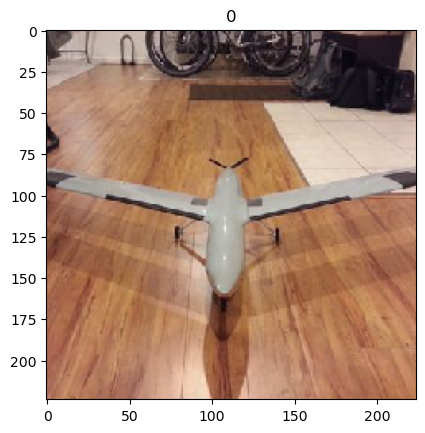

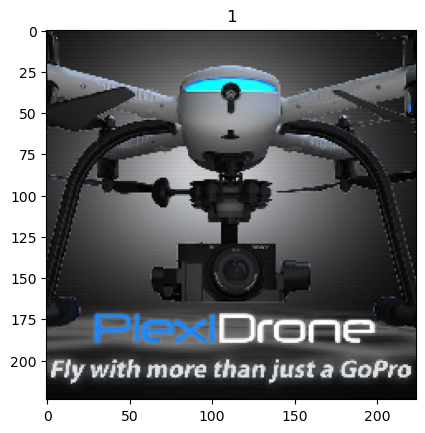

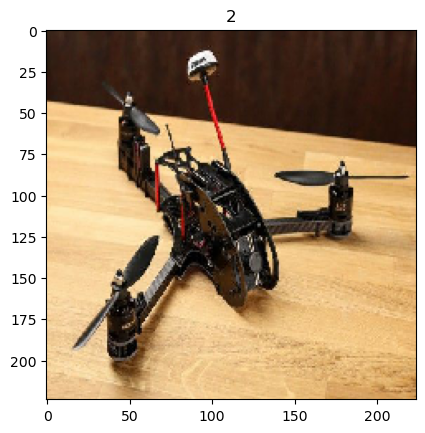

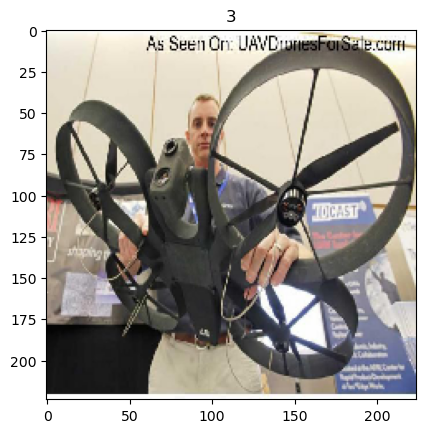

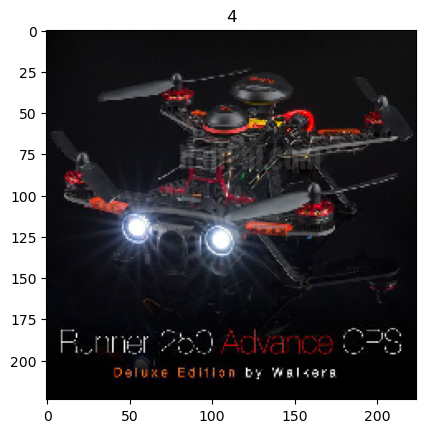

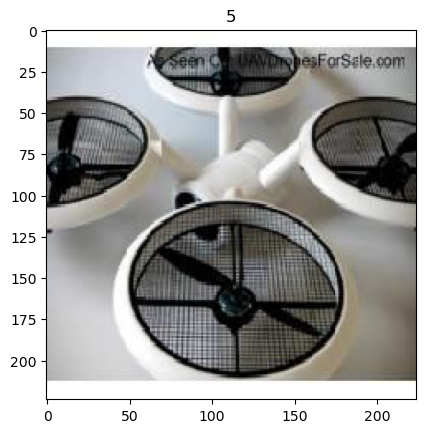

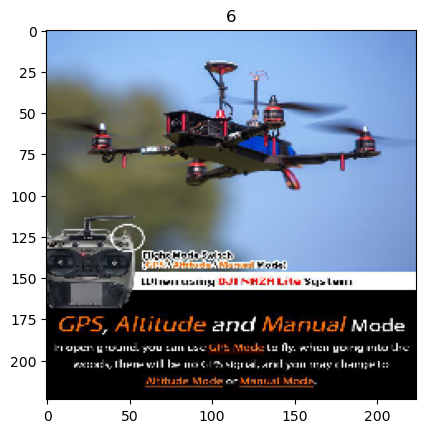

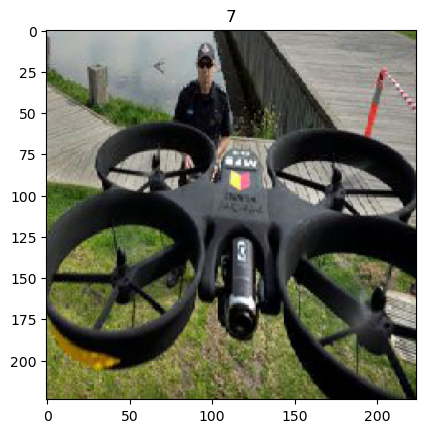

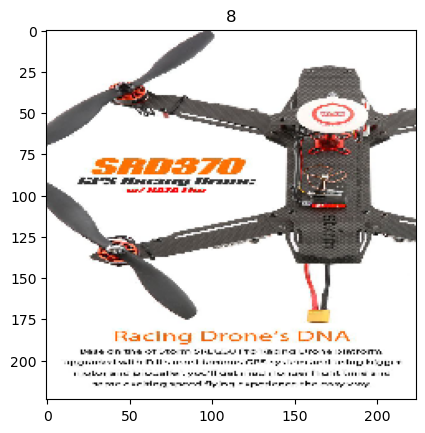

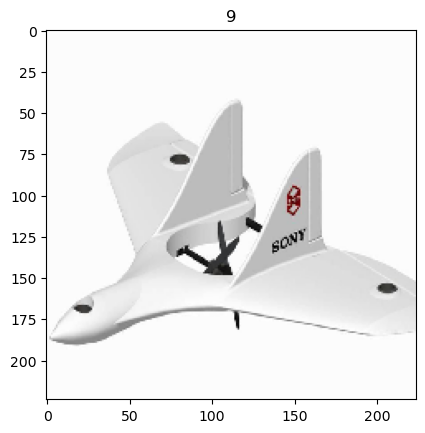

In [41]:
import os
imgs_path1 = r'C:\Users\chana\Downloads'
imgs_model_width, imgs_model_height = 224, 224
a = input('Enter keyword again (use _ for spaces):')
b = imgs_path1 +'\\'+ a + '\\'
nb_closest_images = 5 # number of most similar images to retrieve
data = [b + x for x in os.listdir(b)]

print("number of images:",len(data))

i = 0
while i<10:
    original = load_img(data[i], target_size=(imgs_model_width, imgs_model_height))
    plt.figure()
    plt.imshow(original)
    plt.title(i)
    
    i=i+1
       

Enter id for most suitable image:2
C:\Users\chana\Downloads\drone\809ad5de30056c271e5e50ae8b779df8.jpg
809ad5de30056c271e5e50ae8b779df8.jpg


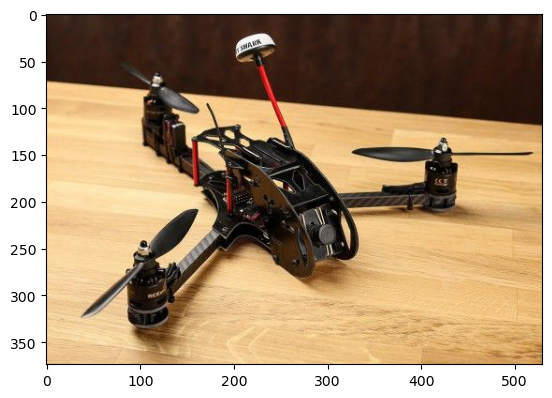

In [42]:

c = int(input("Enter id for most suitable image:"))
d = load_img(data[c])
plt.imshow(d)
s1 = data[c]
#plt.savefig('output.png')
e = s1.replace(b,'')
print(s1)
print(e)


In [43]:
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [44]:
imgs_path2 = r'C:\Users\chana\OneDrive\Documents\final'
imgs_model_width, imgs_model_height = 224, 224

import shutil
s2 = imgs_path2 +'\\' + e

if s2 in files:
    index = files.index(s2)
    l = load_img(files[index])
    new_index= index
    #plt.imshow(l)
else:
    
    shutil.move(s1, imgs_path2+'\\'+e)
    k = load_img(files[-1])
    new_index= -1
    #plt.imshow(k)

In [45]:
nb_closest_images = 5 # number of most similar images to retrieve
files = [imgs_path2 +'\\'+ x for x in os.listdir(imgs_path2)]

print("number of images:",len(files))
#print(*files,sep = "\n")




number of images: 1359


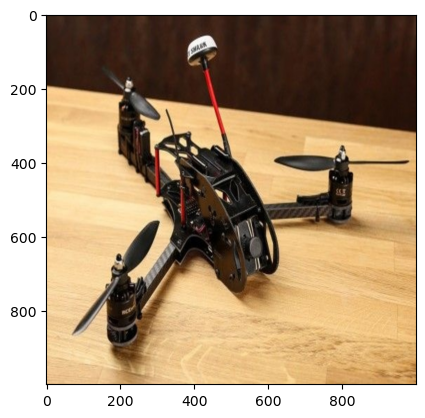

In [46]:
index = files.index(s2)
l = load_img(files[index])
new_index= index
plt.imshow(l)

In [48]:
importedImages = []
import os
import PIL
from PIL import UnidentifiedImageError

#for item in os.listdir(imgs_path):
for item in files:
    if not item.startswith('.') and os.path.isfile(os.path.join(imgs_path2, item)):
        try:
            original = load_img(item, target_size=(224, 224))
            numpy_image = img_to_array(original)
            image_batch = np.expand_dims(numpy_image, axis=0)
            importedImages.append(image_batch)
        except PIL.UnidentifiedImageError:
            print(item)
        

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [49]:
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(1359, 4096)

In [50]:
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

C:\Users\chana\OneDrive\Documents\final\000a1059a1c03dcc05968fd4b933efec.jpg  \
C:\Users\chana\OneDrive\Documents\final\000a105...                                           1.000000                              
C:\Users\chana\OneDrive\Documents\final\0017cae...                                           0.371990                              
C:\Users\chana\OneDrive\Documents\final\0036ee3...                                           0.181759                              
C:\Users\chana\OneDrive\Documents\final\0038b85...                                           0.254501                              
C:\Users\chana\OneDrive\Documents\final\00390fc...                                           0.427254                              

                                                    C:\Users\chana\OneDrive\Documents\final\0017cae380a37be23eff974443260851.jpg  \
C:\Users\chana\OneDrive\Documents\final\000a105...                                           0.371990                              
C:\Users\chana\OneDrive\Documents\final\0017cae...                                           1.000000                              
C:\Users\chana\OneDrive\Documents\final\0036ee3...                                           0.204540                              
C:\Users\chana\OneDrive\Documents\final\0038b85...                                           0.318979                              
C:\Users\chana\OneDrive\Documents\final\00390fc...                                           0.237145                              

                                                    C:\Users\chana\OneDrive\Documents\final\0036ee36e4b4316a543b7580864befec.png  \
C:\Users\chana\OneDrive\Documents\final\000a105...                                           0.181759                              
C:\Users\chana\OneDrive\Documents\final\0017cae...                                           0.204540                              
C:\Users\chana\OneDrive\Documents\final\0036ee3...                                           1.000000                              
C:\Users\chana\OneDrive\Documents\final\0038b85...                                           0.275797                              
C:\Users\chana\OneDrive\Documents\final\00390fc...                                           0.095561                              

                                                    C:\Users\chana\OneDrive\Documents\final\0038b855990c342284c4f6002f926519.jpg  \
C:\Users\chana\OneDrive\Documents\final\000a105...                                           0.254501                              
C:\Users\chana\OneDrive\Documents\final\0017cae...                                           0.318979                              
C:\Users\chana\OneDrive\Documents\final\0036ee3...                                           0.275797                              
C:\Users\chana\OneDrive\Documents\final\0038b85...                                           1.000000                              
C:\Users\chana\OneDrive\Documents\final\00390fc...                                           0.262319                              

                                                    C:\Users\chana\OneDrive\Documents\final\00390fc2b5448b80e2b13c6a65885bfd.jpg  \
C:\Users\chana\OneDrive\Documents\final\000a105...                                           0.427254                              
C:\Users\chana\OneDrive\Documents\final\0017cae...                                           0.237145                              
C:\Users\chana\OneDrive\Documents\final\0036ee3...                                           0.095561                              
C:\Users\chana\OneDrive\Documents\final\0038b85...                                           0.262319                              
C:\Users\chana\OneDrive\Documents\final\00390fc...                                           1.000000                              

                                                    C:\Users\chana\OneDrive\Documents\f

In [51]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


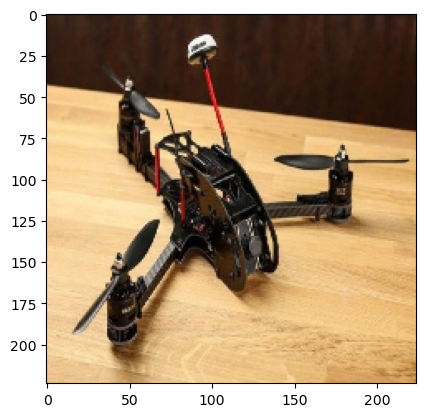

-----------------------------------------------------------------------
most similar products:


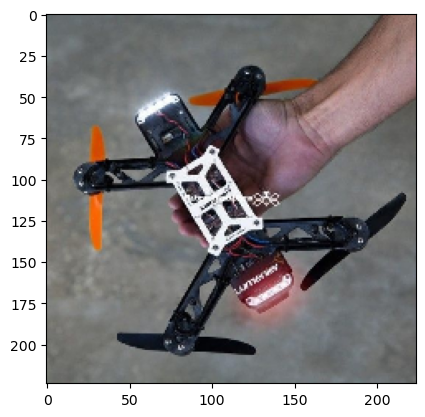

similarity score :  0.49976724


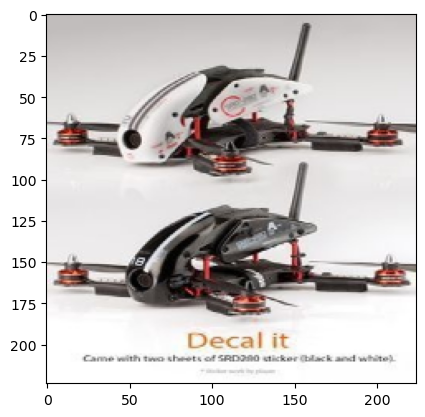

similarity score :  0.47076818


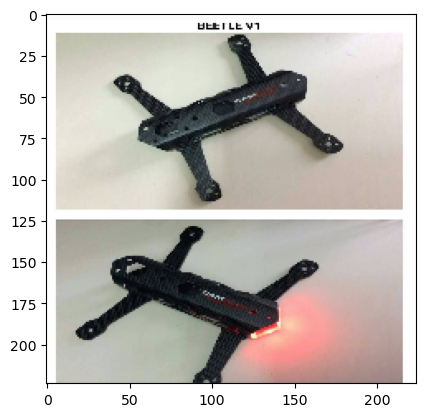

similarity score :  0.46581987


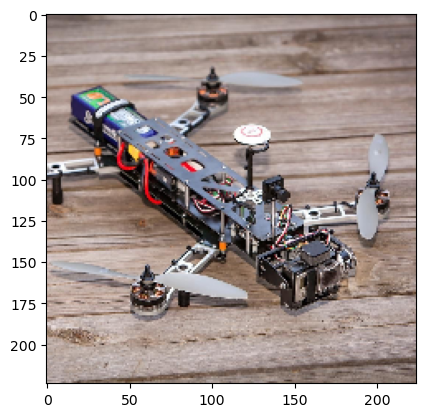

similarity score :  0.4640995


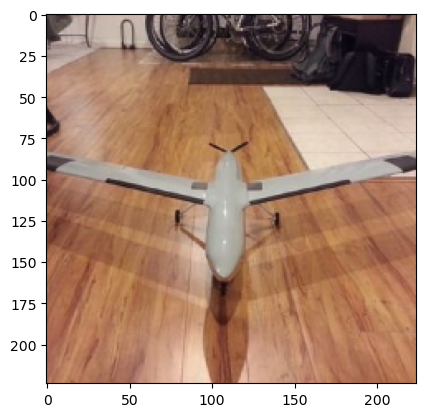

similarity score :  0.45870033


In [52]:
retrieve_most_similar_products(files[new_index])